# Why I should Convince My Wife To Get A Smart Thermostat
This notebook uses **Plotly** for zoomable, interactive charts to explore:
- Indoor temperature trends
- AC activation detection
- Correlation with outdoor temperature and humidity
- Hourly AC event patterns
- Highlight of Nighttime bed room temperature increase

In [2]:

import pandas as pd
import numpy as np
from datetime import timedelta


import matplotlib.pyplot as plt
import seaborn as sns
 


## 1. Load Data and Problem Hypothesis

The Indoor Room Temperature data was collected by myself using an Arduino Uno R4 connected to the cloud logging temperature values every 5 minutes in my house. The reason for the analysis is when we're sleeping the temperature always gets warm and uncomforatble. My Hypothesis for the reson this occures is because during the night our AC is running less and thus our body heat warms the temperature of the room. This leads to discomfort in both my wife and my son. A few solutions will be explored throughout this data dive that can help bring light to some home HVAC issues. 

At the End of the day. `When the Bedroom is occupied the temperature will increase over time` the other hypothesis that will be explored is `When Outdoor temperature Exceeds 25 F above house temp the AC cycles more frequently` 

End goal of this analysis is to see just how much my AC is running and potenital solutions to my house fighting the Florida Heat. 

In [3]:
df = pd.read_csv('combined_weather_data_with_fahrenheit.csv', parse_dates=['time'])
df.set_index('time', inplace=True)
df.head()

,indoor_temp,indoor_humidity,outdoor_temp,outdoor_temp_f
time,,,,
2025-07-07 00:00:51.551702053,75.379997,48,25.5,77.9
2025-07-07 00:05:53.537485912,75.019997,48,25.5,77.9
2025-07-07 00:10:55.496729582,74.660004,48,25.5,77.9
2025-07-07 00:15:57.471704348,75.379997,48,25.5,77.9
2025-07-07 00:20:59.442412762,75.019997,48,25.5,77.9


## 2. Detect Possible AC Activations

#### How Often Does My AC Actually Run?

This section automatically flags potential AC "turn-on" events using sudden drops in temperature (greater than 0.3°F over 5 minutes). These red dots will appear later on our plots to help us visualize when the AC is doing the heavy lifting.

If it’s running constantly or erratically, it might mean poor insulation, improper thermostat placement, or worse — a system that's cycling too fast and not doing its job effectively.


In [4]:
df['temp_delta'] = df['indoor_temp'].diff()
ac_events = df[df['temp_delta'] < -0.3]
ac_events = ac_events.copy()
ac_events['event'] = 'AC Turn-On'

print(f'Detected {len(ac_events)} possible AC events.')

Detected 1634 possible AC events.


## 3. Interactive Temperature Timeline

#### Daily Temperature Overview: Indoor vs. Florida

Here we track the room (bedroom) temperature compared to the outdoor temp. The dotted line is the outdoor temperature and the solid is indoor.

You'll notice red dots scattered across the indoor temp — each is a time where the AC likely turned on. What’s interesting is how often it has to fight to bring the temp back down… sometimes over and over in just a few hours. We’ll go deeper in the next plot.


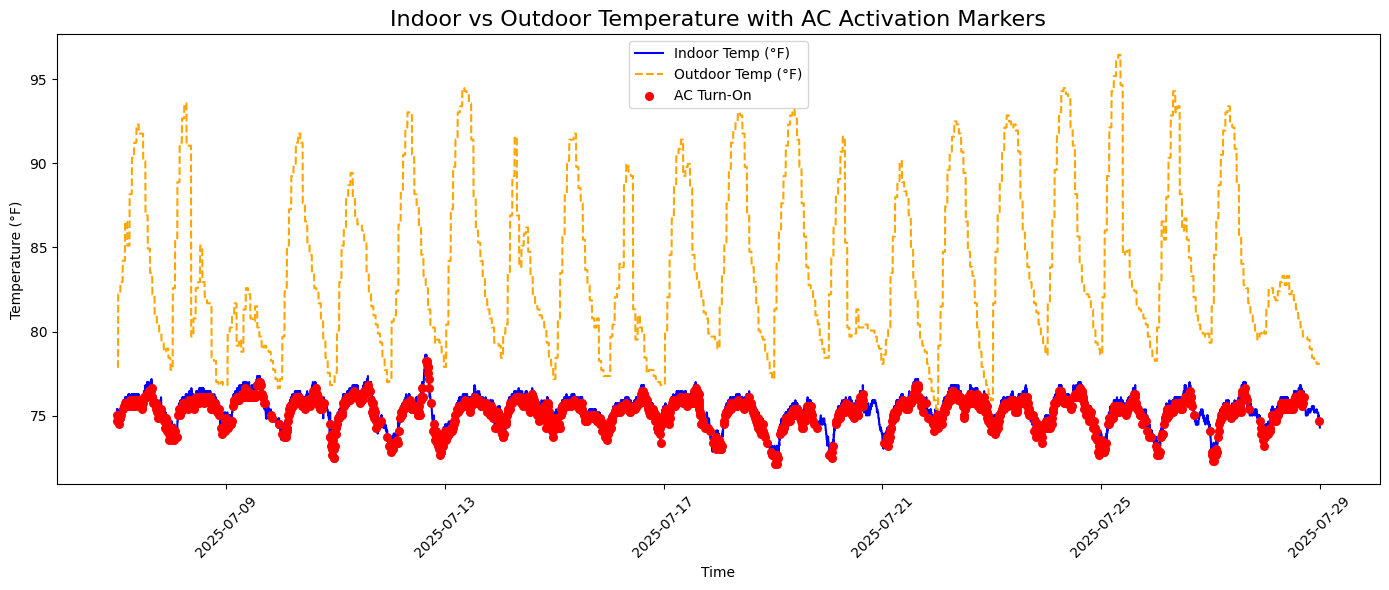

In [5]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Plot indoor temp
ax.plot(df.index, df['indoor_temp'], label='Indoor Temp (°F)', color='blue', linewidth=1.5)

# Plot outdoor temp (dashed)
ax.plot(df.index, df['outdoor_temp_f'], label='Outdoor Temp (°F)', color='orange', linestyle='--', linewidth=1.5)

# Plot AC events as red dots
ax.scatter(ac_events.index, ac_events['indoor_temp'], label='AC Turn-On', color='red', s=30, zorder=5)

# Labels and legend
ax.set_title('Indoor vs Outdoor Temperature with AC Activation Markers', fontsize=16)
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°F)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

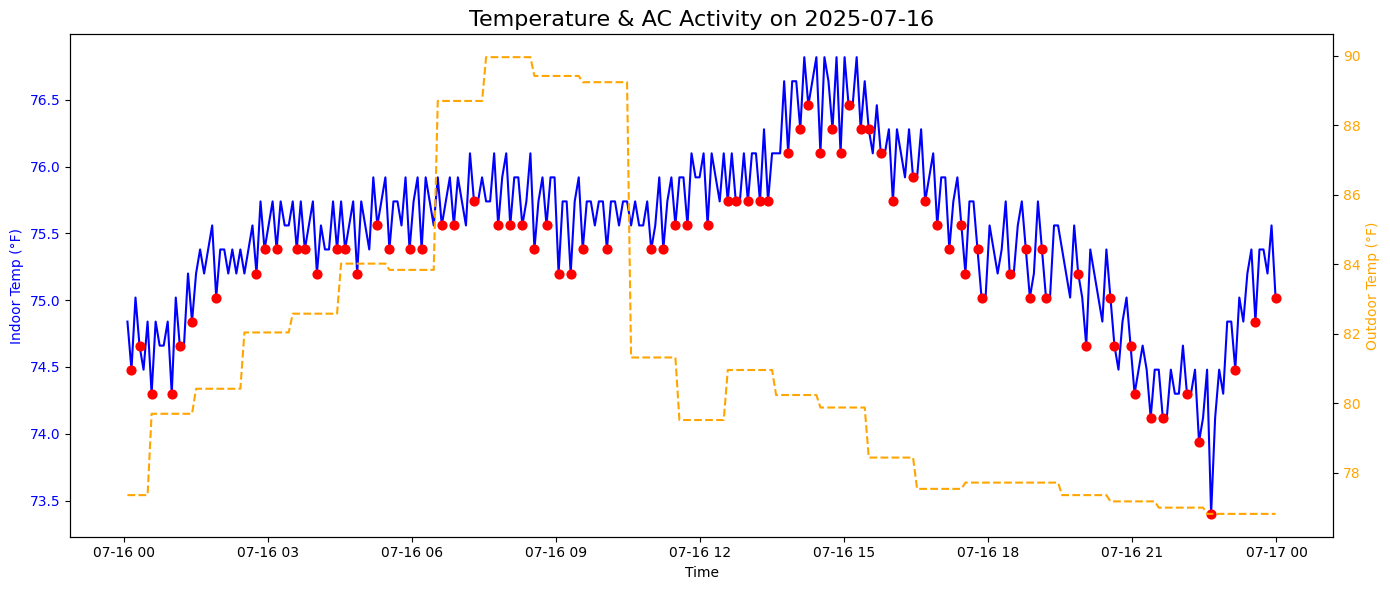

In [6]:

# Define the day to zoom in
zoom_day = '2025-07-16'
start = pd.to_datetime(f"{zoom_day} 00:00:00")
end = pd.to_datetime(f"{zoom_day} 23:59:59")

df_day = df.loc[start:end]
ac_day = ac_events.loc[start:end]

# Create the figure and dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot indoor temp on primary y-axis
ax1.plot(df_day.index, df_day['indoor_temp'], label='Indoor Temp (°F)', color='blue', linewidth=1.5)
ax1.scatter(ac_day.index, ac_day['indoor_temp'], label='AC Turn-On', color='red', s=40, zorder=5)
ax1.set_ylabel("Indoor Temp (°F)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for outdoor temp
ax2 = ax1.twinx()
ax2.plot(df_day.index, df_day['outdoor_temp_f'], label='Outdoor Temp (°F)', color='orange', linestyle='--', linewidth=1.5)
ax2.set_ylabel("Outdoor Temp (°F)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and x-axis
plt.title(f"Temperature & AC Activity on {zoom_day}", fontsize=16)
ax1.set_xlabel("Time")
plt.xticks(rotation=45)
fig.tight_layout()

##### Zooming into a day

Above is a snapshot of a day, there is some interesting insight to draw from my bedroom temp and the outdoor temperature, you can see that steadily throughout the day as we approach 90 deg F the Bedroom Temperature begins to rise with rapid amounts of AC cooling but no matter how many times it cycles we still cannot achieve the thermostat stepoint of 74. 

One note is that the living room where the thermostat currently lives is always at 74 with minimal fluctuaitons. 

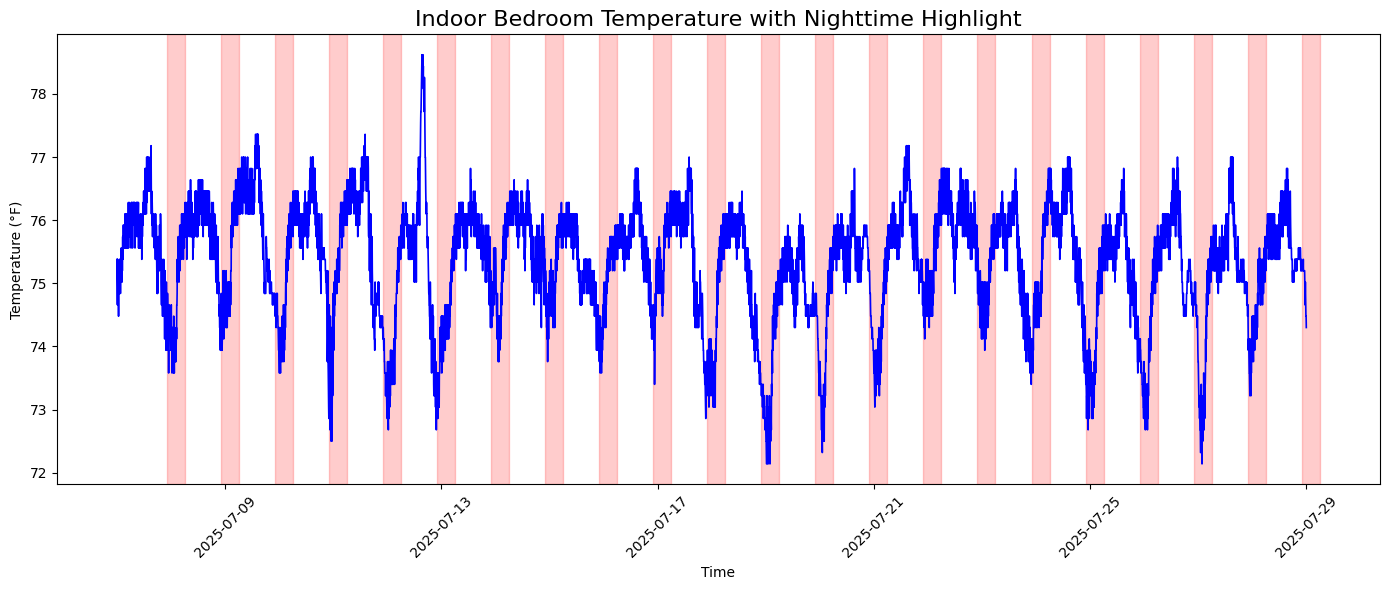

In [7]:
# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot indoor temperature
ax.plot(df.index, df['indoor_temp'], label='Indoor Temp (°F)', color='blue', linewidth=1.2)

# Highlight nighttime periods
for day in pd.to_datetime(df.index.date).unique():
    night_start = pd.Timestamp(f"{day} 22:00:00")
    night_end = pd.Timestamp(f"{day + pd.Timedelta(days=1)} 06:00:00")
    ax.axvspan(night_start, night_end, color='red', alpha=0.2)

# Labels and legend
ax.set_title("Indoor Bedroom Temperature with Nighttime Highlight", fontsize=16)
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (°F)")
plt.xticks(rotation=45)
plt.tight_layout()

#### Nighttime Temperature Trouble

This visualization confirms our suspicion. At night (shaded in red), the AC cycles less — probably because the outdoor air is cooler. But with 2–3 people sleeping in a sealed room, body heat raises the room temperature noticeably.

Over multiple nights, the pattern repeats. This tells us the AC system isn't adapting to real-time occupancy — something a smart thermostat could easily solve using motion or door sensors.


## Is Humidity Part of the Problem?

When your AC kicks on, it doesn’t just cool the air — it also removes moisture. We can see some dips in humidity, especially after AC activations.

However, during the night, the humidity often stays flat or rises slightly, supporting the theory that the system is doing very little once we’re asleep. That’s a comfort killer — and possibly contributing to morning grogginess.


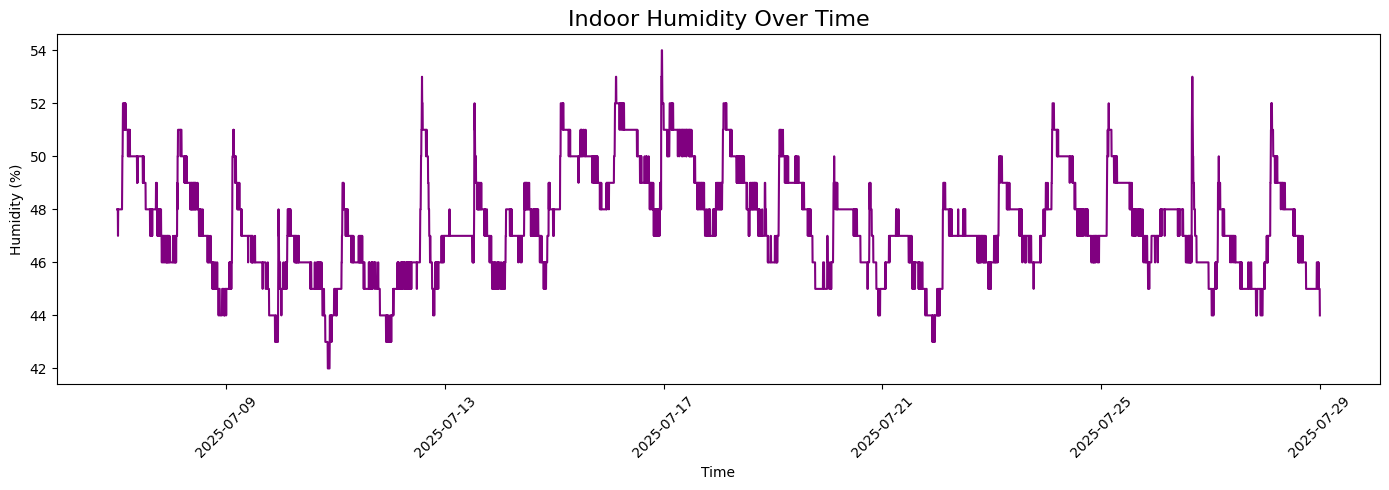

In [8]:
# Create figure
fig, ax = plt.subplots(figsize=(14, 5))

# Plot indoor humidity
ax.plot(df.index, df['indoor_humidity'], color='purple', linewidth=1.5)

# Labels and title
ax.set_title("Indoor Humidity Over Time", fontsize=16)
ax.set_xlabel("Time")
ax.set_ylabel("Humidity (%)")
plt.xticks(rotation=45)
plt.tight_layout()

## 5. Daily AC Event Frequency vs Outdoor Temp

## Hotter Days = More AC Work

Here we compare the number of AC events per day with the average outdoor temp.

The trend is clear: as outdoor temps creep up, the system kicks on more often to fight the heat. But what’s more concerning is **how inconsistent** the cycling behavior is one day it may cycle 50 times, another over 100. This is wear and tear, energy usage, and noise all compounding.

A smart thermostat could learn these cycles and make small adjustments to **reduce the number of on/off events** ultimately saving energy and making the house feel more stable.


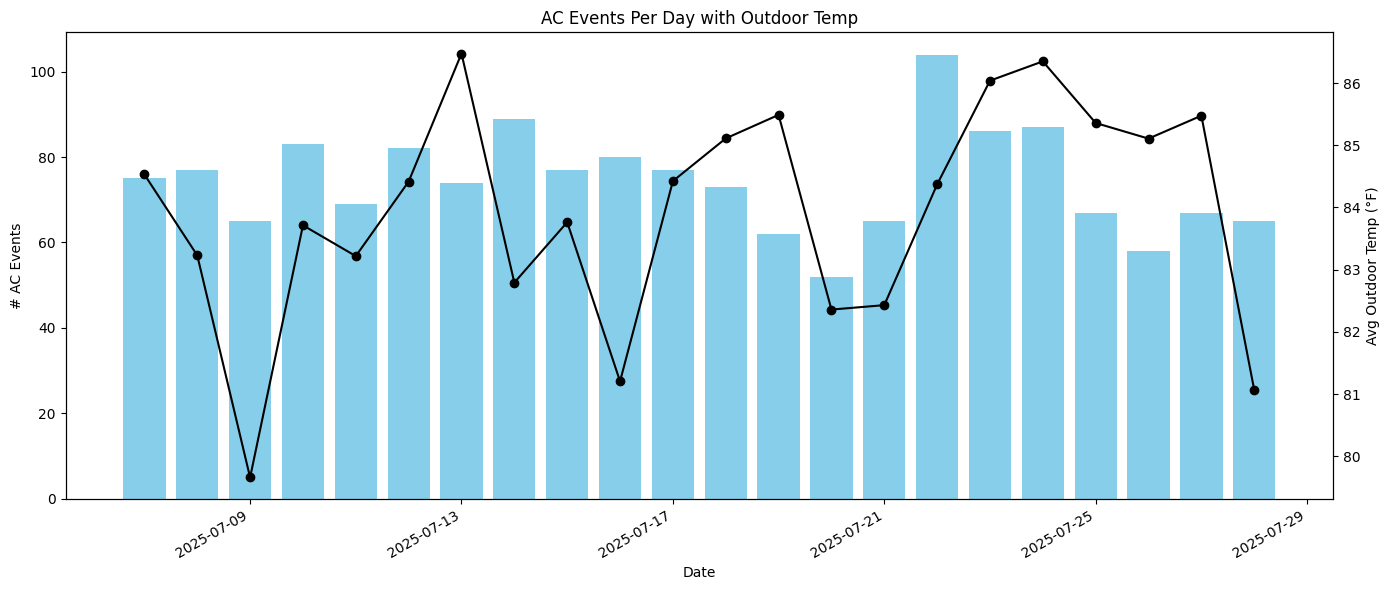

In [13]:
# Prepare data
ac_events['date'] = ac_events.index.date
df['date'] = df.index.date

daily_ac_counts = ac_events.groupby('date').size().reset_index(name='ac_events')
daily_avg_outdoor = df.groupby('date')['outdoor_temp_f'].mean().reset_index(name='avg_outdoor_temp')
summary = pd.merge(daily_ac_counts, daily_avg_outdoor, on='date')

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for AC events
ax1.bar(summary['date'], summary['ac_events'], color='skyblue', label='# AC Events')
ax1.set_ylabel('# AC Events', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Line plot for average outdoor temp
ax2 = ax1.twinx()
ax2.plot(summary['date'], summary['avg_outdoor_temp'], color='black', marker='o', label='Avg Outdoor Temp (°F)')
ax2.set_ylabel('Avg Outdoor Temp (°F)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Titles and formatting
plt.title('AC Events Per Day with Outdoor Temp')
ax1.set_xlabel('Date')
fig.autofmt_xdate()
fig.tight_layout()

## The Bedroom Hourly Temperature Curve

Here’s the average bedroom temp over a full day. Notice that dip in the evening and the slow climb after midnight — that’s the system taking a break when we need it most.

A smart thermostat could schedule a more aggressive overnight cooling plan based on this insight alone.


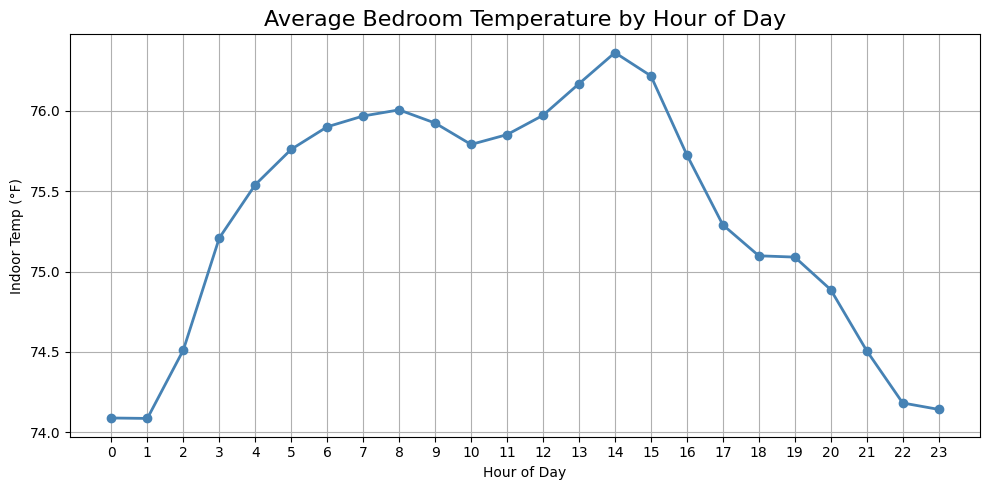

In [14]:
# Extract hour and compute hourly average
df['hour'] = df.index.hour
hourly_temp = df.groupby('hour')['indoor_temp'].mean().reset_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hourly_temp['hour'], hourly_temp['indoor_temp'], marker='o', color='steelblue', linewidth=2)

# Labels and title
ax.set_title("Average Bedroom Temperature by Hour of Day", fontsize=16)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Indoor Temp (°F)")
ax.set_xticks(range(0, 24))
ax.grid(True)
plt.tight_layout()

## Humidity Isn't Helping Either

This scatterplot shows the relationship between indoor temperature and humidity. As the room warms up, the humidity creeps up slightly as well.

That means we're not just getting hotter we’re getting muggier. Even though the trendline isn’t steep, small increases in humidity at sleep-critical temps can mean the difference between comfortable and clammy.

A smart thermostat could better manage **humidity removal** during the night or even suggest switching the fan on periodically to maintain dryness and prevent stuffiness.


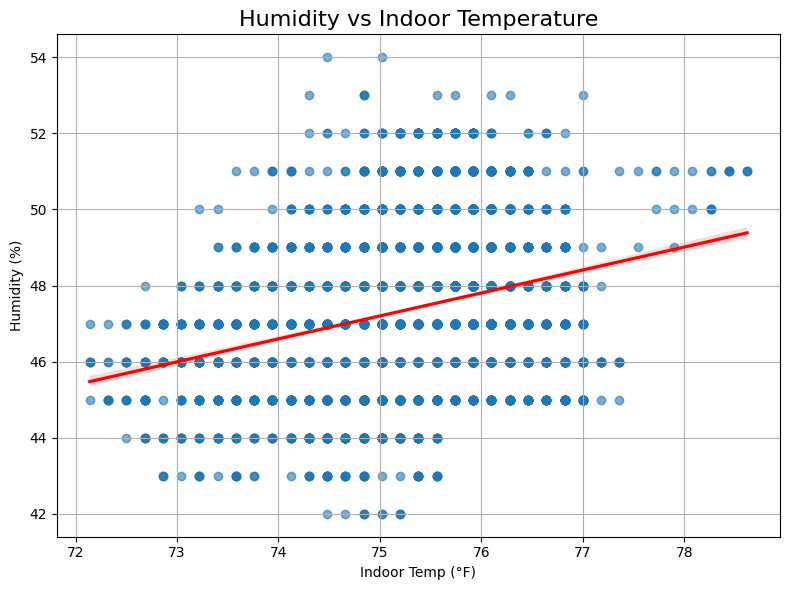

In [15]:
# Create scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x='indoor_temp', y='indoor_humidity', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})

# Labels and title
plt.title("Humidity vs Indoor Temperature", fontsize=16)
plt.xlabel("Indoor Temp (°F)")
plt.ylabel("Humidity (%)")
plt.grid(True)
plt.tight_layout()

## So... Is My AC Fighting a Losing Battle?

The data makes one thing very clear: **my AC is working hard - maybe too hard - to keep up with the Florida heat**. Whether it’s cycling dozens of times a day, letting the room warm up while we sleep, or just battling humidity inch by inch, this system is brute-forcing its way through summer.

### Let’s Revisit the Hypotheses:

- **“When the bedroom is occupied, the temperature will increase over time.”**  
  Confirmed. During the night, when we’re all in the room and the AC naturally backs off, the temperature rises — and so does discomfort.

- **“When outdoor temperature exceeds 25°F above indoor, the AC cycles more often.”**  
  Nailed it. You can practically hear it running in that 3 PM–6 PM spike. The closer the sun gets to boiling the roof, the more often the AC flips on just to tread water.

---

## So What Can We Do?

This isn’t a “buy new HVAC” moment — the system works. But it’s reactive, not smart. Here’s where we **take control**:

-  **Smart Thermostat** — learns occupancy, humidity, and trends to *pre-cool* or adjust at night. No more random wake-ups in a hot room.
-  **Room-Based Sensors** — tell the thermostat the bedroom is still too warm even when the hallway is fine.
-  **Night Schedule Tweaks** — keep the fan running intermittently, or cool just a degree more before bed to coast through sleep hours.
-  **Energy Monitoring** — measure how much we're running now vs. with smarter logic, and dial in long-term savings.

---

At the end of the day, this analysis shows one simple truth:

> **We're not cooling a house — we're cooling a life.**  
> And if a few sensors and an app can help us sleep better, wake up cooler, and maybe even save money?  
> That’s not an upgrade. That’s peace of mind.


So to anyone reading this please join my cause in convicing my wife that a smart thermostat wont only save money but it will incrase satisfaction for her and my young son! 